## Installation and Imports

In [ ]:
! pip install biosignalsnotebooks

In [2]:
! pip3 install ishneholterlib

In [3]:
! wget http://thew-project.org/document/1-300mECG.zip
! unzip /content/1-300mECG.zip

--2024-09-03 12:48:30--  http://thew-project.org/document/1-300mECG.zip
Resolving thew-project.org (thew-project.org)... 128.151.146.136
Connecting to thew-project.org (thew-project.org)|128.151.146.136|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 680061 (664K) [application/x-zip-compressed]
Saving to: ‘1-300mECG.zip’

1-300mECG.zip       100%[===================>] 664.12K   728KB/s    in 0.9s    

2024-09-03 12:48:31 (728 KB/s) - ‘1-300mECG.zip’ saved [680061/680061]

Archive:  /content/1-300mECG.zip
  inflating: 1-300m.ecg              


In [4]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import biosignalsnotebooks as bsnb
from scipy.signal import detrend
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
from ishneholterlib import Holter
import numpy as np

In [6]:
import os
from datetime import datetime
from PIL import Image
import random

In [7]:
import cv2

In [ ]:
! rm -r EKM_dataset_big_EKM/
! rm -r EKM_dataset/

In [ ]:
# DON'T RUN!
! mkdir EKM_dataset
! mkdir EKM_dataset/x_lead
! mkdir EKM_dataset/y_lead
! mkdir EKM_dataset/z_lead

In [8]:
! mkdir EKM_dataset_big_EKM
! mkdir EKM_dataset_big_EKM/x_lead
! mkdir EKM_dataset_big_EKM/y_lead
! mkdir EKM_dataset_big_EKM/z_lead

In [9]:
import shutil

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
len(os.listdir("/content/drive/MyDrive/ECG project/ECG_200"))

403

## Initial variables (codes for different status)

In [12]:
# default values for fields that may be set/edited by the user
header_field_defaults = {
    'file_version':  -9,
    'first_name':    '',
    'last_name':     '',
    'id':            '',
    'sex':           0,
    'race':          0,
    'birth_date':    None,
    'pm':            -9,
    'recorder_type': '',  # TODO?: 'unknown'
    'proprietary':   '',
    'copyright':     '',
    'reserved':      '',
    'var_block':     ''
}

# numeric codes from Table 1 of ISHNE Holter spec
lead_specs = {
    -9: 'absent', 0: 'unknown', 1: 'generic',
    2: 'X',    3: 'Y',    4: 'Z',
    5: 'I',    6: 'II',   7: 'III',
    8: 'aVR',  9: 'aVL', 10: 'aVF',
    11: 'V1', 12: 'V2',  13: 'V3',
    14: 'V4', 15: 'V5',  16: 'V6',
    17: 'ES', 18: 'AS',  19: 'AI'
}

# numeric codes from Table 2 of ISHNE Holter spec
lead_qualities = {
    -9: 'absent',
    0: 'unknown',
    1: 'good',
    2: 'intermittent noise',
    3: 'frequent noise',
    4: 'intermittent disconnect',
    5: 'frequent disconnect'
}

# type of pacemaker
pm_codes = {
    0: 'none',  # i.e. no PM installed.  so -9 should be used for unknown.
    1: 'unknown type',
    2: 'single chamber unipolar',
    3: 'dual chamber unipolar',
    4: 'single chamber bipolar',
    5: 'dual chamber bipolar',
}

gender_codes = {
    0: None,  # unknown
    1: 'M',
    2: 'F'
}

# race codes.  other values (e.g. 4+) may also be used, but weren't in the initial spec
race_codes = {
    0: None,  # unknown
    1: 'caucasian',
    2: 'black',
    3: 'oriental',
}


## Preprocessing by pan tompkins algorithm

In [14]:
# Load a file from disk:
all_data = Holter('/content/1-300m.ecg')
all_data.load_data()

In [15]:
x_lead = all_data.lead[0]
y_lead = all_data.lead[1]
z_lead = all_data.lead[2]

In [16]:
x_lead.data

array([0.058536, 0.058536, 0.014634, ..., 0.19512 , 0.209754, 0.229266])

In [17]:
def process_ecg(unfiltered_ecg, fs):
    # Step 1 of Pan-Tompkins Algorithm - ECG Filtering (Bandpass between 5 and 15 Hz)
    filtered_signal = bsnb.detect._ecg_band_pass_filter(unfiltered_ecg, fs)
    # Step 2 of Pan-Tompkins Algorithm - ECG Differentiation
    differentiated_signal = np.diff(filtered_signal)
    # Step 3 of Pan-Tompkins Algorithm - ECG Rectification
    squared_signal = differentiated_signal * differentiated_signal
    # Step 4 of Pan-Tompkins Algorithm - ECG Integration ( Moving window integration )
    nbr_sampls_int_wind = int(0.080 * fs)
    integrated_signal = np.zeros_like(squared_signal)
    cumulative_sum = squared_signal.cumsum()
    integrated_signal[nbr_sampls_int_wind:] = (cumulative_sum[nbr_sampls_int_wind:] - cumulative_sum[
                                                                                      :-nbr_sampls_int_wind]) / nbr_sampls_int_wind
    integrated_signal[:nbr_sampls_int_wind] = cumulative_sum[:nbr_sampls_int_wind] / np.arange(1, nbr_sampls_int_wind + 1)
    # Initialisation of the R peak detection algorithm
    rr_buffer, signal_peak_1, noise_peak_1, threshold = bsnb.detect._buffer_ini(integrated_signal, fs)
    # Detection of possible and probable R peaks
    probable_peaks, possible_peaks = bsnb.detect._detects_peaks(integrated_signal, fs)
    # Identification of definitive R peaks
    definitive_peaks = bsnb.detect._checkup(probable_peaks, integrated_signal, fs, rr_buffer, signal_peak_1,
                                            noise_peak_1, threshold)
    # Conversion to integer type.
    definitive_peaks = np.array(list(map(int, definitive_peaks)))
    # Correcting step
    map_integers = definitive_peaks - 40 * (fs / 1000)
    definitive_peaks_reph = np.array(list(map(int, map_integers)))
    return definitive_peaks_reph, filtered_signal

In [18]:
# Normalizing method
def normalize(signal):
    a, b = -1, 1
    c = b - a
    aux = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
    norm_ecg = c * aux + a
    return norm_ecg

In [19]:
# Calculates the mean distance between all peaks for each user
def peak_distance(r_peaks):
    dist = []
    for i in range(len(r_peaks)):
        if r_peaks[i] == r_peaks[-1]:
            break
        distance = r_peaks[i + 1] - r_peaks[i]
        if i == 0:
            dist.append(distance)
            continue
        if distance > np.mean(dist) + np.std(dist) * 2:
            continue
        else:
            dist.append(distance)
    return np.mean(dist)

In [20]:
def electrocardiomatrix(distance, r_peaks, filtered_ecg, init_window, peaks_window):
    init_seg = int(0.2 * distance)
    fin_seg = int(1.5 * distance)
    all_segments = []
    for peak in r_peaks[init_window:init_window + peaks_window]:
        if peak - init_seg < 0:
            segment = filtered_ecg[0:peak + fin_seg]
        else:
            segment = filtered_ecg[peak - init_seg:peak + fin_seg]
        all_segments.append(segment[:,np.newaxis])
    if all_segments[0].shape[0] < all_segments[1].shape[0]:
        zeros = np.zeros(int(all_segments[1].shape[0])-int(all_segments[0].shape[0]))[:, np.newaxis]
        new_segment = np.concatenate((zeros, all_segments[0]))
        all_segments[0] = new_segment
    try:
      ecm = np.concatenate(all_segments, 1)
    except ValueError:
      return None
    return ecm.T

In [21]:
def electrocardiomatrix_no_1(filtered_ecg, init_window, sampling_rate, window_size):
  fs = sampling_rate
  window_signal_sample_size = window_size * fs
  each_line_ekm_size = 1 # seconds
  each_line_ekm_sample_signal_size = each_line_ekm_size * fs
  all_segments = []

  for ekm_line in range(window_size):
    segment = filtered_ecg[init_window + (ekm_line * each_line_ekm_sample_signal_size): \
                init_window + ((ekm_line+1) * each_line_ekm_sample_signal_size)]
    all_segments.append(segment)

  ecm = all_segments

  return ecm

In [22]:
# Labeling is in this way that, prelast element of EKM's name is the user's id,
# and the last element is the number of the EKM for that user
def save_ecm(dataset_name, path, key, i):
    # Saving EKMs in format of {path}/_NumberOfbpfsInAEKM_bpf-ekm-{key=user id}-{i=serial Number}
    plt.savefig(f"{path}/10bpf-ekm-{dataset_name}-{key}-{str(i)}",bbox_inches='tight', pad_inches=0)

In [23]:
def little_ekm_dataset(lead_data, sampling_rate, dataset_name, ekms_path, key):
  print("  .Preprocessing the signal")
  peaks, filtered_ecg = process_ecg(lead_data , sampling_rate)

  print("  .Getting detrend_signal, norm_ecg, distance")
  detrend_signal = detrend(filtered_ecg)
  norm_ecg = normalize(detrend_signal)
  distance = peak_distance(peaks)

  # by fs=200, 2 seconds will be 10 bpf
  # bpf => 2(s) / 200 * 0.001
  bpf = 10
  peaks_window = bpf-1
  data_obtained = []
  distances = []
  negative = True
  ekms_counter, init_window = 0, 0
  total_ecms = 3000

  fig_width_px = 33
  fig_height_px = 21

  print("  .Getting EKMs")
  while(ekms_counter<total_ecms):
    if (init_window >= len(peaks)) or (init_window >= len(peaks)-1): break
    ecm = electrocardiomatrix(distance, peaks, norm_ecg, init_window, peaks_window)
    if ecm is None: break
    distance = int(distance)
    norm_ecm = normalize(ecm)

    fig = plt.figure(num=1, clear=True, figsize=(fig_width_px / 80, fig_height_px / 80))
    ax = fig.add_subplot()
    ax.axis('off')

    sns.heatmap(norm_ecm, xticklabels=False, yticklabels=False, cbar=False)
    # plt.tight_layout()

    save_ecm(dataset_name, ekms_path, key, ekms_counter)
    ekms_counter += 1
    # break

In [24]:
def big_ekm_dataset(lead_data, sampling_rate, dataset_name, ekms_path, key):
  print("  .Preprocessing the signal")
  peaks, filtered_ecg = process_ecg(lead_data , sampling_rate)

  print("  .Getting detrend_signal, norm_ecg, distance")
  detrend_signal = detrend(filtered_ecg)
  norm_ecg = normalize(detrend_signal)
  distance = peak_distance(peaks)

  # by fs=200, 2 seconds will be 10 bpf
  # bpf => 2(s) / 200 * 0.001
  bpf = 10
  peaks_window = bpf-1
  data_obtained = []
  distances = []
  negative = True
  ekms_counter, init_window = 0, 0
  total_ecms = 3000

  print("  .Getting EKMs")
  while(ekms_counter<total_ecms):
    if (init_window >= len(peaks)) or (init_window >= len(peaks)-1): break
    ecm = electrocardiomatrix(distance, peaks, norm_ecg, init_window, peaks_window)
    if ecm is None: break
    distance = int(distance)
    norm_ecm = normalize(ecm)

    sns.heatmap(norm_ecm, xticklabels=False, yticklabels=False, cbar=False)
    # plt.tight_layout()

    save_ecm(dataset_name, ekms_path, key, ekms_counter)
    init_window += bpf
    ekms_counter += 1
    # break

In [25]:
def pretier_print(pos, userNumber, usr_ecg_file_name):
  if pos == "begin":
    [print("-", end="") for i in range(30)]
    print("")
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print(f"-> User No.{userNumber}")
    print("")
    print(usr_ecg_file_name)

  if pos == "end":
    print("")
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print("")

### Big EKMs dataset

In [27]:
sampling_rate = all_data.sr
dataset_name = "big_ekm_sample"
base_big_ekms_path = f'EKM_dataset_big_EKM'
train_split_percent = 0.8
key = "1"

sample_users_signals = [x_lead, y_lead, z_lead]

lead_names_dict = {
    1: "x_lead",
    2: "y_lead",
    3: "z_lead"
}

In [28]:
sample_users_signals

In [29]:
# lead_path = base_big_ekms_path + "/" + lead_names_dict[_ + 1]
lead_data = sample_users_signals[0].data
ekms_path = base_big_ekms_path + "/" + lead_names_dict[0 + 1]

In [30]:
ekms_path

'EKM_dataset_big_EKM/x_lead'

In [31]:
# big_ekm_dataset(lead_data.data, sampling_rate, dataset_name, lead_path, key)
print("  .Preprocessing the signal")
peaks, filtered_ecg = process_ecg(lead_data , sampling_rate)

print("  .Getting detrend_signal, norm_ecg, distance")
detrend_signal = detrend(filtered_ecg)
norm_ecg = normalize(detrend_signal)
distance = peak_distance(peaks)

# by fs=200, 2 seconds will be 10 bpf
# bpf => 2(s) / 200 * 0.001
bpf = 10
peaks_window = bpf-1
data_obtained = []
distances = []
negative = True
ekms_counter, init_window = 0, 0
total_ecms = 3000

  .Preprocessing the signal
  .Getting detrend_signal, norm_ecg, distance


In [32]:
norm_ecg

array([0.12510338, 0.10694632, 0.07986104, ..., 0.10027668, 0.11225453,
       0.12508011])

In [33]:
peaks

array([     2,    256,    494, ..., 299263, 299496, 299729])

In [ ]:
def _electrocardiomatrix(distance, r_peaks, filtered_ecg, init_window, peaks_window):
    # should create EKMs with the all possible peaks in 4 seconds and 6 seconds
    # and let the what left in the end of window of signal.
    # also its good to make the window size flexable.
    init_seg = int(0.2 * distance)
    fin_seg = int(1.5 * distance)
    all_segments = []

    # should walk trougth the 4 and 6 seconds signal (loop between 4 )
    for peak in r_peaks[init_window:init_window + peaks_window]:
        if peak - init_seg < 0:
            segment = filtered_ecg[0:peak + fin_seg]
        else:
            segment = filtered_ecg[peak - init_seg:peak + fin_seg]
        all_segments.append(segment[:, np.newaxis])

    if all_segments[0].shape[0] < all_segments[1].shape[0]:
        zeros = np.zeros(int(all_segments[1].shape[0])-int(all_segments[0].shape[0]))[:, np.newaxis]
        new_segment = np.concatenate((zeros, all_segments[0]))
        all_segments[0] = new_segment
    try:
      ecm = np.concatenate(all_segments, 1)
    except ValueError:
      return None
    return ecm.T

In [37]:
init_seg = int(0.2 * distance)
fin_seg = int(1.5 * distance)

In [184]:
# Defining start distance/delay which is the distance till first peak
start_delay = peaks[0]

In [185]:
sbf = 6
bpf = 5
one_EKM_signal_size = sbf * sampling_rate

In [186]:
EKM_counter = 0
one_EKM_norm_signal = norm_ecg[one_EKM_signal_size * EKM_counter : one_EKM_signal_size * (EKM_counter + 1)]

In [187]:
peaks

array([     2,    256,    494, ..., 299263, 299496, 299729])

In [188]:
# Getting r peaks of one EKM (bpf + sbf)
r_peaks_one_EKM = []
for r_peak_ind in peaks:
  lower_bound = one_EKM_signal_size * (EKM_counter)
  upper_bound = one_EKM_signal_size * (EKM_counter + 1)
  if r_peak_ind <= upper_bound and r_peak_ind >= lower_bound:
    r_peaks_one_EKM.append(r_peak_ind)

In [189]:
r_peaks_one_EKM

[2, 256, 494, 744, 992]

In [190]:
defficient_peaks_flag = False
if len(r_peaks_one_EKM) >= bpf:
  r_peaks_one_EKM = r_peaks_one_EKM[0:bpf]
else:
  defficient_peaks_flag = True

In [191]:
r_peaks_one_EKM

[2, 256, 494, 744, 992]

In [192]:
defficient_peaks_flag

False

In [193]:
all_segments = []

for peak in r_peaks_one_EKM:
  segment = norm_ecg[peak - start_delay : peak + fin_seg]
  all_segments.append(segment)

In [194]:
len(all_segments)

5

In [195]:
norm_all_segments = normalize(all_segments)

In [196]:
# Zero padding when there are less r_peaks than bpf amount
if defficient_peaks_flag == True:
  zeros = np.zeros(len(segment))
  norm_all_segments = np.vstack((norm_all_segments, zeros))

<Axes: >

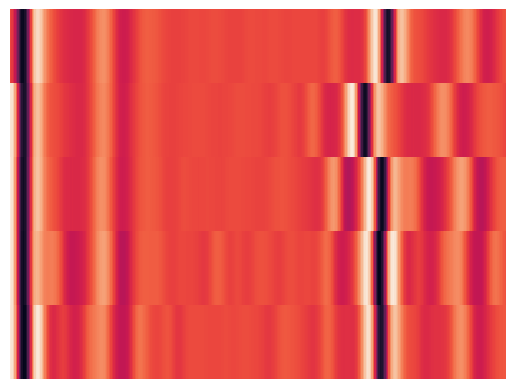

In [197]:
sns.heatmap(norm_all_segments, xticklabels=False, yticklabels=False, cbar=False)